## Deeplab v3
This notebook trains Deeplab v3 models using previously exported earth observation data from Google Earth Engine

In [0]:
!pip install PyDrive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import glob
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

In [0]:
auth.authenticate_user()

In [0]:
!rm -r tensorflow-deeplab-v3

In [0]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=POGbATWCUkpnKHMkAwtGB3MC3HdgvNvrwqg2NJztn4E&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/xgFN26WTUeDlbirLgNYSYUZswVIW5Ia19me0IoSUE9LJ-KZrZ9T3nTo

Successfully saved authorization token.


In [0]:
# export training data from Google Earth Engine
counties = ee.FeatureCollection("TIGER/2018/Counties")
NAIP = ee.ImageCollection("USDA/NAIP/DOQQ")
ny = ee.FeatureCollection("TIGER/2018/States").filterMetadata('NAME', 'equals', 'New York')
monroe = counties.filterBounds(ny).filterMetadata("NAME", 'equals', 'Monroe')
# geometry = ee.Geometry.Polygon(
#         [[[-77.59801470072598, 43.093595496557896],
#           [-77.59801470072598, 43.019341104439505],
#           [-77.4943312290463, 43.019341104439505],
#           [-77.4943312290463, 43.093595496557896]]], None, False)

landcover = ee.Image.constant(0).rename('landcover').clip(monroe).float()

monroeNAIP = NAIP.filterBounds(monroe)\
.filterDate('2017-01-01', '2020-01-01')\
.median()\
.clip(monroe)\
.addBands(landcover)

task = ee.batch.Export.image.toCloudStorage(
  image = monroeNAIP.select(['R', 'G', 'B', 'landcover']),
  region = monroe.geometry(),
  scale = 1,
  maxPixels = 1e13,
  description = 'monroe_NY_NAIP_predict',
  bucket = 'cvod-203614-mlengine',
  fileNamePrefix ='LI_parking/data/predict/monroeCounty',
  fileFormat = 'TFRecord',
  formatOptions = { 
      'patchDimensions': 512,
      'kernelSize': 256,
      'compressed': True,
      'maxFileSize': 104857600
  }
)

task.start()

In [0]:
# verify the export worked
!gsutil ls gs://cvod-203614-mlengine/LI_parking/data/predict/*

Clone our github repo containing the functions to build, train, and predict a Deeplab v3 model. 
TODO: maintain an up-to-date version of this repo in GDrive and change this notebook to read from those files

In [0]:
!git clone https://github.com/mjevans26/tensorflow-deeplab-v3.git

Cloning into 'tensorflow-deeplab-v3'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 433 (delta 46), reused 0 (delta 0), pack-reused 357
Receiving objects: 100% (433/433), 462.98 KiB | 1.51 MiB/s, done.
Resolving deltas: 100% (273/273), done.


### Train a model
To train from scratch point to a resnet backbone. To continue training from a previous checkpoint, set 'pre_trained_model' argument to chekpoint file

In [0]:
!python tensorflow-deeplab-v3/train_parking.py --model_dir gs://cvod-203614-mlengine/LI_parking/models/deeplab --bands R G B --freeze_batch_norm False --data_dir gs://cvod-203614-mlengine/LI_parking/data --batch_size 8 --train_epochs 50 --epochs_per_eval 10 --initial_learning_rate 0.001 --pre_trained_model gs://cvod-203614-mlengine/resnet_v2_101/resnet_v2_101.ckpt 

In [0]:
%load_ext tensorboard
%tensorboard --logdir gs://cvod-203614-mlengine/LI_parking/models/deeplab

Inspect input prediction data

In [0]:
def input_fn(fileNames, numEpochs=None, shuffle=True, batchSize=16, side=512+(256/2)):
  ds = tf.data.TFRecordDataset(fileNames, compression_type='GZIP')
#these feature names have to match the 'outputFeatures' field in the TFRecord export from EE.
  features = {
        'R': tf.FixedLenFeature([side, side], tf.float32), # Define mask of exported GEE kernels. Remind GEE issue that exported assets are always in float32
        'G': tf.FixedLenFeature([side, side], tf.float32),
        'B': tf.FixedLenFeature([side, side], tf.float32),
        'landcover': tf.FixedLenFeature([side, side], tf.float32) #this might be needed for multiclass labels that get turned into one-hot vectors
  }
  
  def parse(example_proto):
    parsed_features = tf.parse_single_example(example_proto, features)
    # Separate the class labels from the training features
    labels = parsed_features.pop('landcover')
    #labels = tf.one_hot(tf.cast(tf.add(labels, -1), tf.uint8), 2)
    # For faster training / stability, we'll bring our reflectance values into
    # the range [0, 1]
    return parsed_features, labels

  ds = ds.map(parse, num_parallel_calls=5)

  if shuffle:
    # We choose 30 since, with a batch size of 100, we'll keep 3000 (the size
    # of the training data) examples in memory for the shuffle
    ds = ds.shuffle(buffer_size = 5000)
    
  ds = ds.batch(batchSize).repeat(numEpochs)
  
  iterator = ds.make_one_shot_iterator()
  features, labels = iterator.get_next()
  
  return features, labels

In [0]:
# Inspect the incoming TFRecords
fileList = !gsutil ls gs://cvod-203614-mlengine/LI_parking/data/predict/*tfrecord.gz
print(len(fileList))
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    features, labels = input_fn(fileNames = fileList, side = 512+256, shuffle = True, batchSize = 1)
    stack = tf.stack([features[x] for x in ['R', 'G', 'B']], axis=3)
    #assert not np.any(np.isnan(test))
    print(sess.run(fetches = labels))

1855

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


### Make predictions

In [0]:
# Run predictions
!python tensorflow-deeplab-v3/inference.py --data_dir gs://cvod-203614-mlengine/LI_parking/data/predict --model_dir '/content/drive/My Drive/Tensorflow/LI_parking/models/deeplab' --output_dir gs://cvod-203614-mlengine/LI_parking/data/predict/output/deeplab512/monroe_10870 --bands R G B --patch_dims 512 --buffer_size 256

In [0]:
# Determine the number of tfrecord files written for predictions
outFiles = !gsutil ls gs://cvod-203614-mlengine/LI_parking/data/predict/output/deeplab512/*.tfrecord
n = len(outFiles)
print(n)

In [0]:
!rm dataset/inference_output/*

In [0]:
!pip install earthengine-api


In [0]:
!earthengine --no-use_cloud_api authenticate --quiet

Paste the following address into a web browser:

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code

On the web page, please authorize access to your Earth Engine account and copy the authentication code. Next authenticate with the following command:

    earthengine authenticate --authorization-code=PLACE_AUTH_CODE_HERE



In [0]:
!earthengine --no-use_cloud_api authenticate --authorization-code='4/sgG7I36HgtsYcQtRdhz1oc2YSDvX7yl8Mc-K-YEoPmIeLPzz1e0xSZ0'


Successfully saved authorization token.


In [0]:
# Generate list of prediction files
out_image_file = " ".join(['gs://cvod-203614-mlengine/LI_parking/data/predict/output/deeplab512/monroe_10870-{:05}.tfrecord'.format(i) for i in range(0,n)])
print(out_image_file)

gs://cvod-203614-mlengine/LI_parking/data/predict/output/deeplab512/monroe_10870-00000.tfrecord gs://cvod-203614-mlengine/LI_parking/data/predict/output/deeplab512/monroe_10870-00001.tfrecord gs://cvod-203614-mlengine/LI_parking/data/predict/output/deeplab512/monroe_10870-00002.tfrecord gs://cvod-203614-mlengine/LI_parking/data/predict/output/deeplab512/monroe_10870-00003.tfrecord gs://cvod-203614-mlengine/LI_parking/data/predict/output/deeplab512/monroe_10870-00004.tfrecord gs://cvod-203614-mlengine/LI_parking/data/predict/output/deeplab512/monroe_10870-00005.tfrecord gs://cvod-203614-mlengine/LI_parking/data/predict/output/deeplab512/monroe_10870-00006.tfrecord gs://cvod-203614-mlengine/LI_parking/data/predict/output/deeplab512/monroe_10870-00007.tfrecord gs://cvod-203614-mlengine/LI_parking/data/predict/output/deeplab512/monroe_10870-00008.tfrecord gs://cvod-203614-mlengine/LI_parking/data/predict/output/deeplab512/monroe_10870-00009.tfrecord gs://cvod-203614-mlengine/LI_parking/dat

In [0]:
# point to the json sidecar file that was exported with the prediction imagae
jsonFile = !gsutil ls gs://cvod-203614-mlengine/LI_parking/data/predict/*.json

In [0]:
# Set the asset name we want the predictions to have in GEE
out_image_asset = 'users/defendersofwildlifeGIS/LongIsland/parking_deeplab_monroe_10k'

In [0]:
!earthengine --no-use_cloud_api upload image --asset_id={out_image_asset} {out_image_file} {jsonFile[0]}


Started upload task with ID: JALJW3OMFN7UPVVG2UXX3REH


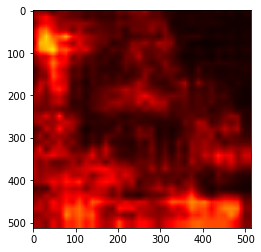

In [0]:
import glob
pred_files = glob.glob('dataset/inference_output/*.npy')
array = np.load(pred_files[13])
import matplotlib.pyplot as plt
img = plt.imshow(array[:, :, 1], cmap = 'hot', interpolation = 'nearest', vmin = 0, vmax = 1)